In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import img_to_array,array_to_img,load_img
from keras import backend as K
from keras.layers import Input
from scipy.optimize import fmin_l_bfgs_b
import time


Using TensorFlow backend.


In [2]:
from google.colab import files 
uploaded = files.upload()

Saving architecture-building-city-1123982.jpg to architecture-building-city-1123982.jpg
Saving art-artistic-bright-1317559.jpg to art-artistic-bright-1317559.jpg


In [0]:
for k,v in uploaded.items():
  open(k,'wb').write(v)
im = list(uploaded.keys())

In [0]:
target_height = 512
target_width = 512
target_size = (512,512)


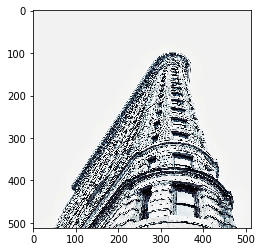

W0723 20:15:32.629728 139641082337152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



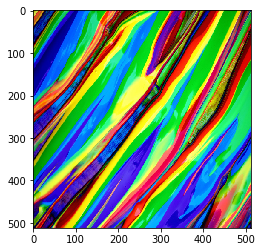

In [5]:
content_image = load_img(im[0],target_size=target_size)
plt.imshow(content_image)
plt.show()
style_image = load_img(im[1],target_size=target_size)
plt.imshow(style_image)
content_image_size_orig = content_image.size
content_array = img_to_array(content_image)
content_array = K.variable(preprocess_input(np.expand_dims(content_array,axis=0)),dtype="float32")

style_array = img_to_array(style_image)
style_array = K.variable(preprocess_input(np.expand_dims(style_array,axis=0)),dtype='float32')

gen_image = np.random.randint(256,size=(target_width,target_height,3)).astype('float32')
gen_image = preprocess_input(np.expand_dims(gen_image,axis=0))

gen_image_placeholder = K.placeholder(shape=(1,target_width,target_height,3))
plt.show()

In [0]:
def get_features(placeholder,layers_names,model):
  feature_matrices = []
  for layer in layers_names:
    selected_layer = model.get_layer(layer)
    features = selected_layer.output
    featRawShape = K.shape(features).eval(session=tf_session)
    N_1 = featRawShape[-1]
    M_1 = featRawShape[1]*featRawShape[2]
    featMatrix = K.reshape(features,(M_1,N_1))
    featMatrix = K.transpose(featMatrix)
    feature_matrices.append(featMatrix)
  return feature_matrices  

In [0]:
def get_content_loss(F,P):
  cLoss = 0.5*(K.sum(K.square(F-P)))
  return cLoss

In [0]:
def get_gram_matrix(F):
  G = K.dot(F,K.transpose(F))
  return G


In [0]:
def get_style_loss(ws,Gs,As):
  sLoss = K.variable(0.)
  for w,G,A in zip(ws,Gs,As):
    M_1 = K.int_shape(G)[1]
    N_1 = K.int_shape(G)[0]
    G_gram = get_gram_matrix(G)
    A_gram = get_gram_matrix(A)
    sLoss += w*0.24*K.sum(K.square(G_gram-A_gram))/(N_1**2*M_1**2)
  return sLoss

    

In [0]:
def get_total_loss(gen_image_placeholder,alpha=1.0,beta=1000.0):
  F = get_features(gen_image_placeholder,layers_names=[cLayer_name],model=gModel)[0]
  Gs = get_features(gen_image_placeholder,layers_names=sLayer_name,model=gModel)
  contentLoss = get_content_loss(F,P)
  styleLoss = get_style_loss(ws,Gs,As)
  totalLoss = alpha*contentLoss+beta*styleLoss
  return totalLoss

  

In [0]:
def calculate_loss(gen_img_arr):
  if gen_img_arr.shape != (1,target_width,target_height,3):
    gen_img_arr = gen_img_arr.reshape(1,target_width,target_height,3)
  loss_fcn = K.function([gModel.input],[get_total_loss(gModel.input)])
  return loss_fcn([gen_img_arr])[0].astype("float64")


In [0]:
def get_grad(gen_img_arr):
  if gen_img_arr.shape != (1,target_width,target_height,3):
    gen_img_arr = gen_img_arr.reshape(1,target_width,target_height,3)
  grad_fcn = K.function([gModel.input],K.gradients(get_total_loss(gModel.input),[gModel.input]))
  grad = grad_fcn([gen_img_arr])[0].flatten().astype('float64')
  return grad

In [0]:
def postprocess_array(x):
    # Zero-center by mean pixel
    if x.shape != (target_width, target_height, 3):
        x = x.reshape((target_width, target_height, 3))
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x


In [0]:
def reprocess_array(x):
    x = np.expand_dims(x.astype('float64'), axis=0)
    x = preprocess_input(x)
    return x

In [0]:
def save_original_size(x, target_size=content_image_size_orig):
    xIm = Image.fromarray(x)
    xIm = xIm.resize(target_size)
    xIm.save(genImOutputPath)
    return xIm


In [16]:
tf_session = K.get_session()
cModel = VGG19(include_top=False,weights='imagenet',input_tensor=content_array)
sModel = VGG19(include_top=False,weights='imagenet',input_tensor=style_array)
gModel =  VGG19(include_top=False,weights='imagenet',input_tensor=gen_image_placeholder)
cLayer_name = 'block5_conv2'
sLayer_name = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
		            'block5_conv1']
P = get_features(placeholder=content_array,layers_names=[cLayer_name],model=cModel)[0]
As = get_features(placeholder=style_array,layers_names=sLayer_name,model=sModel)
ws = np.ones(len(sLayer_name))//float(len(sLayer_name))

W0723 20:15:47.891533 139641082337152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 20:15:47.893293 139641082337152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0723 20:15:47.896599 139641082337152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0723 20:15:47.993476 139641082337152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0723 20:15:48.509355 139641082337152 

80142336/80134624 [==============================] - 3s 0us/step


In [0]:
iterations = 600
x_val = gen_image.flatten()  
start = time.time()

xopt, f_val, info = fmin_l_bfgs_b(calculate_loss,x_val,fprime=get_grad,maxiter=iterations,disp=True)
end = time.time()
print(end-start)
xOut = postprocess_array(xopt)


W0723 20:16:31.210471 139641082337152 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
 plt.imshow(xOut)
plt.show()